In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Solve gpu issue for pytorch
# https://discuss.pytorch.org/t/pytorch-1-8-0-fasterrcnn-resnet50-fpn-error/114150/11

In [3]:
import numpy as np
import cv2
import os
import re

# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

/home/yizhou/miniconda3/envs/rlgpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
from dataset import HandleDataset, get_train_transform, collate_fn

In [6]:
train_dataset = HandleDataset("/home/yizhou/Research/temp/", num_frames = 5, \
                              transforms = get_train_transform()) #

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

 99%|██████████████████████████████████████████████████████████████████████▏| 175/177 [00:00<00:00, 477.75it/s]


NotADirectoryError: [Errno 20] Not a directory: '/home/yizhou/Research/temp//fasterrcnn_resnet50_fpn.pth/bounding_box_2d_tight_0.npy'

In [9]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [10]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


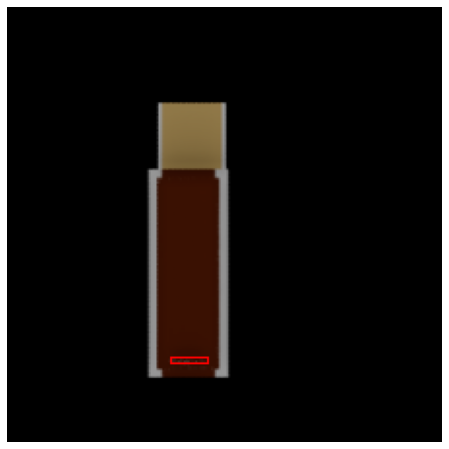

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

In [12]:
len(train_dataset)

874

# Model

In [7]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [8]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [9]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# Train

In [18]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [21]:
num_epochs = 20

from tqdm.auto import tqdm

In [22]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    print("epoch", epoch)
    for images, targets, image_ids in tqdm(train_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # if itr % 50 == 0:
        #     print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

epoch 0


 23%|█████████████▏                                            | 50/219 [00:12<00:42,  3.99it/s]

Iteration #50 loss: 0.5045431864771255


 46%|██████████████████████████                               | 100/219 [00:24<00:27,  4.27it/s]

Iteration #100 loss: 0.1789407149933183


 68%|███████████████████████████████████████                  | 150/219 [00:36<00:16,  4.12it/s]

Iteration #150 loss: 0.21298549195674135


 91%|████████████████████████████████████████████████████     | 200/219 [00:48<00:04,  4.13it/s]

Iteration #200 loss: 0.2299786168349417


100%|█████████████████████████████████████████████████████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch #0 loss: 0.29169939179690585
epoch 1


 14%|████████▏                                                 | 31/219 [00:07<00:44,  4.20it/s]

Iteration #250 loss: 0.343188374292855


 37%|█████████████████████▍                                    | 81/219 [00:19<00:33,  4.11it/s]

Iteration #300 loss: 0.34243943913501335


 60%|██████████████████████████████████                       | 131/219 [00:31<00:22,  3.97it/s]

Iteration #350 loss: 0.2752735347875202


 83%|███████████████████████████████████████████████          | 181/219 [00:44<00:09,  3.97it/s]

Iteration #400 loss: 0.2650402637708326


100%|█████████████████████████████████████████████████████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch #1 loss: 0.26269481843856535
epoch 2


  5%|██▎                                       | 12/219 [00:03<00:53,  3.84it/s]

Iteration #450 loss: 0.25965523070582297


 28%|███████████▉                              | 62/219 [00:16<00:38,  4.08it/s]

Iteration #500 loss: 0.19054278888875867


 51%|████████████████████▉                    | 112/219 [00:28<00:25,  4.24it/s]

Iteration #550 loss: 0.12220121242102067


 74%|██████████████████████████████▎          | 162/219 [00:39<00:13,  4.20it/s]

Iteration #600 loss: 0.2991202376665312


 97%|███████████████████████████████████████▋ | 212/219 [00:51<00:01,  4.25it/s]

Iteration #650 loss: 0.13443477429950162


100%|█████████████████████████████████████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch #2 loss: 0.23361227908554968
epoch 3


 20%|███████████▍                                              | 43/219 [00:10<00:41,  4.24it/s]

Iteration #700 loss: 0.24589496905685954


 42%|████████████████████████▋                                 | 93/219 [00:22<00:31,  4.06it/s]

Iteration #750 loss: 0.29653202854980965


 65%|█████████████████████████████████████▏                   | 143/219 [00:35<00:18,  4.07it/s]

Iteration #800 loss: 0.16788462678622829


 88%|██████████████████████████████████████████████████▏      | 193/219 [00:47<00:06,  4.11it/s]

Iteration #850 loss: 0.2828198632173563


100%|█████████████████████████████████████████████████████████| 219/219 [00:53<00:00,  4.06it/s]


Epoch #3 loss: 0.2243793278735122
epoch 4


 11%|██████▎                                                   | 24/219 [00:06<00:46,  4.23it/s]

Iteration #900 loss: 0.15946224392076286


 34%|███████████████████▌                                      | 74/219 [00:18<00:35,  4.14it/s]

Iteration #950 loss: 0.18284693273737032


 57%|████████████████████████████████▎                        | 124/219 [00:30<00:22,  4.21it/s]

Iteration #1000 loss: 0.22394872131501153


 79%|█████████████████████████████████████████████▎           | 174/219 [00:42<00:10,  4.25it/s]

Iteration #1050 loss: 0.18510517905474821


100%|█████████████████████████████████████████████████████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch #4 loss: 0.22039193555634862
epoch 5


  2%|█▎                                                         | 5/219 [00:01<00:59,  3.57it/s]

Iteration #1100 loss: 0.2556472077276942


 25%|██████████████▌                                           | 55/219 [00:13<00:38,  4.26it/s]

Iteration #1150 loss: 0.35854657652318805


 48%|███████████████████████████▎                             | 105/219 [00:25<00:28,  4.00it/s]

Iteration #1200 loss: 0.24164629695720755


 71%|████████████████████████████████████████▎                | 155/219 [00:37<00:16,  3.83it/s]

Iteration #1250 loss: 0.20967833867640845


 94%|█████████████████████████████████████████████████████▎   | 205/219 [00:50<00:03,  4.19it/s]

Iteration #1300 loss: 0.31724792140348257


100%|█████████████████████████████████████████████████████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch #5 loss: 0.20377144604888148
epoch 6


 16%|█████████▌                                                | 36/219 [00:08<00:43,  4.25it/s]

Iteration #1350 loss: 0.1067940148665495


 39%|██████████████████████▊                                   | 86/219 [00:20<00:31,  4.26it/s]

Iteration #1400 loss: 0.12769974526917954


 62%|███████████████████████████████████▍                     | 136/219 [00:32<00:20,  4.15it/s]

Iteration #1450 loss: 0.19743611300118027


 85%|████████████████████████████████████████████████▍        | 186/219 [00:44<00:07,  4.24it/s]

Iteration #1500 loss: 0.2566272094712221


100%|█████████████████████████████████████████████████████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch #6 loss: 0.19405079324704055
epoch 7


  8%|████▌                                                     | 17/219 [00:04<00:47,  4.22it/s]

Iteration #1550 loss: 0.1644918341103747


 31%|█████████████████▋                                        | 67/219 [00:16<00:36,  4.12it/s]

Iteration #1600 loss: 0.15931286132054115


 53%|██████████████████████████████▍                          | 117/219 [00:28<00:24,  4.24it/s]

Iteration #1650 loss: 0.19524599842395937


 76%|███████████████████████████████████████████▍             | 167/219 [00:40<00:12,  4.00it/s]

Iteration #1700 loss: 0.06294606118723292


 99%|████████████████████████████████████████████████████████▍| 217/219 [00:52<00:00,  4.18it/s]

Iteration #1750 loss: 0.18812834679182966


100%|█████████████████████████████████████████████████████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch #7 loss: 0.18402145476356407
epoch 8


 22%|████████████▋                                             | 48/219 [00:11<00:40,  4.25it/s]

Iteration #1800 loss: 0.16946537248425916


 45%|█████████████████████████▉                                | 98/219 [00:24<00:31,  3.79it/s]

Iteration #1850 loss: 0.25693396069702334


 68%|██████████████████████████████████████▌                  | 148/219 [00:37<00:17,  4.12it/s]

Iteration #1900 loss: 0.18267125231352427


 90%|███████████████████████████████████████████████████▌     | 198/219 [00:49<00:05,  4.15it/s]

Iteration #1950 loss: 0.10746425871066063


100%|█████████████████████████████████████████████████████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch #8 loss: 0.17176314119460837
epoch 9


 13%|███████▋                                                  | 29/219 [00:07<00:47,  4.02it/s]

Iteration #2000 loss: 0.1340150525601025


 36%|████████████████████▉                                     | 79/219 [00:19<00:33,  4.16it/s]

Iteration #2050 loss: 0.18822021814487372


 59%|█████████████████████████████████▌                       | 129/219 [00:31<00:22,  4.08it/s]

Iteration #2100 loss: 0.16799518385035925


 82%|██████████████████████████████████████████████▌          | 179/219 [00:44<00:09,  4.02it/s]

Iteration #2150 loss: 0.24778501328063338


100%|█████████████████████████████████████████████████████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch #9 loss: 0.17119703156665259
epoch 10


  5%|██▋                                                       | 10/219 [00:02<00:54,  3.85it/s]

Iteration #2200 loss: 0.13735096561016755


 27%|███████████████▉                                          | 60/219 [00:15<00:39,  3.99it/s]

Iteration #2250 loss: 0.11407600382183206


 50%|████████████████████████████▋                            | 110/219 [00:27<00:26,  4.08it/s]

Iteration #2300 loss: 0.10313987577415874


 73%|█████████████████████████████████████████▋               | 160/219 [00:40<00:15,  3.91it/s]

Iteration #2350 loss: 0.2531948716326702


 96%|██████████████████████████████████████████████████████▋  | 210/219 [00:52<00:02,  4.17it/s]

Iteration #2400 loss: 0.1225481945464384


100%|█████████████████████████████████████████████████████████| 219/219 [00:54<00:00,  3.99it/s]


Epoch #10 loss: 0.1705931461661281
epoch 11


 19%|██████████▊                                               | 41/219 [00:10<00:43,  4.10it/s]

Iteration #2450 loss: 0.17063740957139598


 42%|████████████████████████                                  | 91/219 [00:22<00:30,  4.18it/s]

Iteration #2500 loss: 0.1169153675491101


 64%|████████████████████████████████████▋                    | 141/219 [00:34<00:19,  4.06it/s]

Iteration #2550 loss: 0.09127184816097496


 87%|█████████████████████████████████████████████████▋       | 191/219 [00:47<00:07,  3.92it/s]

Iteration #2600 loss: 0.19343046259663654


100%|█████████████████████████████████████████████████████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch #11 loss: 0.16398991071646515
epoch 12


 10%|█████▊                                                    | 22/219 [00:05<00:47,  4.12it/s]

Iteration #2650 loss: 0.12015791338662792


 33%|███████████████████                                       | 72/219 [00:18<00:35,  4.14it/s]

Iteration #2700 loss: 0.11694933877250235


 56%|███████████████████████████████▊                         | 122/219 [00:30<00:24,  3.97it/s]

Iteration #2750 loss: 0.17232881384732684


 79%|████████████████████████████████████████████▊            | 172/219 [00:42<00:11,  4.03it/s]

Iteration #2800 loss: 0.2253247619886602


100%|█████████████████████████████████████████████████████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch #12 loss: 0.1738879349222403
epoch 13


  1%|▊                                                          | 3/219 [00:01<01:14,  2.91it/s]

Iteration #2850 loss: 0.2257975741068691


 24%|██████████████                                            | 53/219 [00:13<00:40,  4.07it/s]

Iteration #2900 loss: 0.2068081240520049


 47%|██████████████████████████▊                              | 103/219 [00:25<00:27,  4.17it/s]

Iteration #2950 loss: 0.19840113248210267


 70%|███████████████████████████████████████▊                 | 153/219 [00:37<00:15,  4.18it/s]

Iteration #3000 loss: 0.14810688842389547


 93%|████████████████████████████████████████████████████▊    | 203/219 [00:49<00:04,  3.95it/s]

Iteration #3050 loss: 0.2328063260748286


100%|█████████████████████████████████████████████████████████| 219/219 [00:53<00:00,  4.06it/s]


Epoch #13 loss: 0.17175236814572936
epoch 14


 16%|█████████                                                 | 34/219 [00:08<00:45,  4.11it/s]

Iteration #3100 loss: 0.14243393628085732


 38%|██████████████████████▏                                   | 84/219 [00:21<00:32,  4.13it/s]

Iteration #3150 loss: 0.15512335932614535


 61%|██████████████████████████████████▉                      | 134/219 [00:34<00:20,  4.10it/s]

Iteration #3200 loss: 0.15668945095484907


 84%|███████████████████████████████████████████████▉         | 184/219 [00:46<00:08,  3.98it/s]

Iteration #3250 loss: 0.1919450243032112


100%|█████████████████████████████████████████████████████████| 219/219 [00:55<00:00,  3.95it/s]


Epoch #14 loss: 0.15771145934829328
epoch 15


  7%|███▉                                                      | 15/219 [00:04<00:52,  3.91it/s]

Iteration #3300 loss: 0.19752312491990348


 30%|█████████████████▏                                        | 65/219 [00:16<00:39,  3.87it/s]

Iteration #3350 loss: 0.1267405376301773


 53%|█████████████████████████████▉                           | 115/219 [00:29<00:26,  3.96it/s]

Iteration #3400 loss: 0.15487752259161724


 75%|██████████████████████████████████████████▉              | 165/219 [00:41<00:13,  4.04it/s]

Iteration #3450 loss: 0.22255834182355208


 98%|███████████████████████████████████████████████████████▉ | 215/219 [00:54<00:00,  4.07it/s]

Iteration #3500 loss: 0.14483507661308542


100%|█████████████████████████████████████████████████████████| 219/219 [00:55<00:00,  3.96it/s]


Epoch #15 loss: 0.1559782806632218
epoch 16


 21%|████████████▏                                             | 46/219 [00:11<00:42,  4.06it/s]

Iteration #3550 loss: 0.13059179057008793


 44%|█████████████████████████▍                                | 96/219 [00:24<00:30,  3.99it/s]

Iteration #3600 loss: 0.21294464436389585


 67%|██████████████████████████████████████                   | 146/219 [00:36<00:18,  4.04it/s]

Iteration #3650 loss: 0.16474648107648623


 89%|███████████████████████████████████████████████████      | 196/219 [00:48<00:05,  4.15it/s]

Iteration #3700 loss: 0.0652269140565684


100%|█████████████████████████████████████████████████████████| 219/219 [00:54<00:00,  4.02it/s]


Epoch #16 loss: 0.15214261011503338
epoch 17


 12%|███████▏                                                  | 27/219 [00:06<00:47,  4.04it/s]

Iteration #3750 loss: 0.34816179457016516


 35%|████████████████████▍                                     | 77/219 [00:19<00:34,  4.11it/s]

Iteration #3800 loss: 0.14953487518311875


 58%|█████████████████████████████████                        | 127/219 [00:31<00:23,  3.95it/s]

Iteration #3850 loss: 0.1622224178556762


 81%|██████████████████████████████████████████████           | 177/219 [00:44<00:10,  4.03it/s]

Iteration #3900 loss: 0.09922446482825392


100%|█████████████████████████████████████████████████████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch #17 loss: 0.14523480753859438
epoch 18


  4%|██▏                                                        | 8/219 [00:02<00:54,  3.88it/s]

Iteration #3950 loss: 0.13674828697636995


 26%|███████████████▎                                          | 58/219 [00:14<00:40,  4.01it/s]

Iteration #4000 loss: 0.1150053650042669


 49%|████████████████████████████                             | 108/219 [00:27<00:27,  4.02it/s]

Iteration #4050 loss: 0.13611014150471565


 72%|█████████████████████████████████████████                | 158/219 [00:39<00:14,  4.12it/s]

Iteration #4100 loss: 0.1258841286806648


 95%|██████████████████████████████████████████████████████▏  | 208/219 [00:52<00:02,  4.07it/s]

Iteration #4150 loss: 0.10285560326005398


100%|█████████████████████████████████████████████████████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch #18 loss: 0.14223169105506162
epoch 19


 18%|██████████▎                                               | 39/219 [00:09<00:43,  4.13it/s]

Iteration #4200 loss: 0.2577060365880579


 41%|███████████████████████▌                                  | 89/219 [00:22<00:32,  4.00it/s]

Iteration #4250 loss: 0.18410743335401253


 63%|████████████████████████████████████▏                    | 139/219 [00:34<00:20,  3.84it/s]

Iteration #4300 loss: 0.10027984229560216


 86%|█████████████████████████████████████████████████▏       | 189/219 [00:47<00:07,  3.90it/s]

Iteration #4350 loss: 0.09996436133413311


100%|█████████████████████████████████████████████████████████| 219/219 [00:54<00:00,  4.01it/s]

Epoch #19 loss: 0.14264308184588725


In [10]:
model_path = '/home/yizhou/Research/temp/fasterrcnn_resnet50_fpn.pth'

In [23]:
torch.save(model.state_dict(), model_path)

# Validation

In [ ]:
model.load_state_dict(torch.load(model_path))

In [45]:
images, targets, image_ids = next(iter(train_data_loader))

In [46]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [47]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

In [48]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


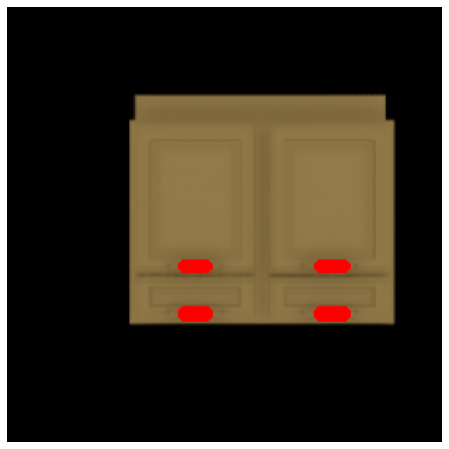

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)